In [1]:
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

In [2]:
class MultiComp:
    def __init__(self, emb_size, n_comp, margin):
        self.pos = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='pos_ph')
        self.neg = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='neg_ph')
        self.lr = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')

        comp_init = np.random.randn(n_comp, emb_size) / np.sqrt(emb_size * n_comp)
        self.sense_comps = tf.Variable(comp_init, dtype=tf.float32, name='senses')
        
        # Attention
        mean_cont = tf.reduce_mean(self.pos, axis=0, keep_dims=True)
        mean_cont = tf.nn.l2_normalize(mean_cont, 1)  # 1 x 100
        
        norm_sens = tf.nn.l2_normalize(self.sense_comps, 1) # n_comp x 100
        
        att = tf.reduce_sum(mean_cont * norm_sens, axis=1, keep_dims=True)
#         noise = tf.random_normal(att.get_shape()) * tf.reduce_mean(att) / 3
#         att += noise
        self.att = att
#         self.att = tf.nn.softmax(att, dim=0)
        word_emb = tf.reduce_sum(self.sense_comps * self.att, axis=0, keep_dims=True)
        
        
        # Cosine loss
        norm_pos = tf.nn.l2_normalize(self.pos, 1)
        norm_neg = tf.nn.l2_normalize(self.neg, 1)
        norm_word_emb = tf.nn.l2_normalize(word_emb, 1)
        
        pos_loss = tf.reduce_mean(tf.reduce_sum(norm_pos * norm_word_emb, axis=1))
        neg_loss = tf.reduce_mean(tf.reduce_sum(norm_neg * norm_word_emb, axis=1))
        
        self.loss = -pos_loss + neg_loss# + 1e-3*tf.nn.l2_loss(self.sense_comps)
#         opt = tf.train.AdamOptimizer(self.lr)
        opt = tf.train.GradientDescentOptimizer(learning_rate=self.lr)
        self.train_op = opt.minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train_on_sample(self, pos_samp, neg_samp, learning_rate):
        feed_dict = {self.pos: pos_samp, self.neg: neg_samp, self.lr: learning_rate}
        loss, att, _ = self.sess.run([self.loss, self.att, self.train_op], feed_dict)
        return loss, att
    
    def predict_on_sample(self, samp):
        return self.sess.run(self.att, {self.pos: samp})
    
    def get_linear_combination(self, samp):
        att,vecs = self.sess.run([self.att, self.sense_comps], {self.pos: samp})
        return np.sum(att*vecs, axis=0)

# Simple Test

In [401]:
net = MultiComp(100, 3, 0.1)

pos = np.random.randn(10, 100)
neg = np.random.randn(10, 100)

net.train_on_sample(pos, neg, 1e-3)

(-0.03888793, array([[ 0.01279021],
        [-0.09264794],
        [ 0.07887924]], dtype=float32))

In [3]:
import pandas as pd

In [4]:
from pymystem3 import Mystem
mystem = Mystem()

In [326]:
f = pd.read_csv("../data/my_data/train.csv", sep='\t')
f.head()
f = f[f.word == 'замок'].context.values
# len(f)

In [221]:
import nltk

# Train

In [5]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("../models/model_big_one.vec", binary=False)

with open("../data/my_data/{}_out.txt".format('замок'), 'r') as f:
    lines = f.readlines()

In [6]:
import nltk
stop_words = nltk.corpus.stopwords.words('russian')

In [7]:
mystem.lemmatize("в деревне у бабушки",)

['в', ' ', 'деревня', ' ', 'у', ' ', 'бабушка', '\n']

In [8]:
def train_model(f, word, cmp=3, lr=1e-2, epoch_num=10, n_context=10, lr_decay=False, do_shuffle=False):

    tf.reset_default_graph()
    n_comps = cmp
    net = MultiComp(100, n_comps, 0.1)


    n_samples = len(f)
#     n_context = 10 # number of words in the context
    emb_dim = 100
    atts = list()
#     epoch_num = 5
    losses = []
    for epoch in range(epoch_num):
    #     batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
        batch_gen = generate_triplet_batch(f, context_max_len=n_context, word=word, 
                                           lemmatize=True, do_shuffle=do_shuffle)
        pbar = tqdm_notebook(batch_gen, total = n_samples)
        print("epoch_num: ", epoch)
        for n, (sample_p, sample_n) in enumerate(pbar):
            if len(sample_p)==0:
                continue

            loss, att = net.train_on_sample(sample_p, sample_n, lr)
            atts.append(att)
            losses.append(loss)

            if n % 100 == 99:
                pbar.set_description("loss {:.3f}".format(float(np.mean(losses[-300:]))))
        if lr_decay:
            lr *= 0.707
    return net

'None'

In [9]:
from copy import deepcopy
from random import shuffle

def generate_triplet_batch(lines, context_max_len, word, lemmatize=False, tfidf=False, do_shuffle=False):
    if tfidf:
        tfidf_tr = TfidfVectorizer()
        vals = tfidf.fit_transform(lines)
        
    voc_size = len(wv.vocab)
    if do_shuffle:
        lines = deepcopy(lines)
        shuffle(lines)
    for j, line in enumerate(lines):
        if lemmatize:
            line = mystem.lemmatize(line)
            line = [t for t in line if t.isalnum()]
        else:
            line = line.split()
        line = list(set(line)-set(stop_words + [word]))
#         print(line)
        embedd_ps = []
        embedd_p = []
#         context = np.random.choice(line, context_max_len)
        context = line
        for i, w in enumerate(context):
            try:
                if tfidf:
                    num = tfidf_tr.vocabulary_[w]
                    embedd_p.append(wv[w]*vals[j, num])
                    print(w, vals[j, num],)
                else:
                    embedd_p.append(wv[w])
            except KeyError:
                continue
        embedd_n = [wv[wv.index2word[i]] for i in np.random.random_integers(0, voc_size-1, len(embedd_p))]
        yield np.array(embedd_p), np.array(embedd_n)

In [399]:
df = pd.read_csv("../data/my_data/train.csv", sep = '\t')
df.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,1,замок,1,NaN,"0-5, 339-344",замок владимира мономаха в любече . многочисле...
1,2,замок,1,NaN,"11-16, 17-22, 188-193","шильонский замок замок шильйон ( ) , известный..."
2,3,замок,1,NaN,299-304,проведения архитектурно - археологических рабо...
3,4,замок,1,NaN,111-116,"топи с . , л . белокуров легенда о завещании м..."
4,5,замок,1,NaN,"134-139, 262-267",великий князь литовский гедимин после успешной...


In [456]:
words_markers = df.word.values

In [477]:
np.array(pred_tmp).shape

(138, 3, 1)

In [589]:
df.head()

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,440,банка,NaN,NaN,"7-12, 36-41",здание банка китая ( макао ) здание банка кита...
1,441,банка,NaN,NaN,"13-18, 201-206",трехлитровая банка во времена ссср такие банки...
2,442,банка,NaN,NaN,"21-26, 58-63, 101-106, 263-268, 538-543",здание национального банка украины в здании на...
3,443,банка,NaN,NaN,"134-139, 262-267, 345-350",зюдфиртель города эссен ( федеральная земля се...
4,444,банка,NaN,NaN,"43-48, 300-305, 381-386, 521-526",ведения боевых действий полевые учреждения бан...


In [13]:
import sklearn
from sklearn.cluster import KMeans
df = pd.read_csv("../data/my_data/active/train.csv", sep='\t')

true = df.gold_sense_id
attens = []
labels = []

km = KMeans(n_clusters=3)
sk = sklearn.cluster.SpectralClustering(2)

wlist = []
for w in df.word:
    if w not in wlist:
        wlist.append(w)

for w in wlist:
    f = df[df.word == w].context.values
    # TODO: train model
    pred_tmp = []
    net = train_model(f, "", cmp=3, do_shuffle=True)
    batch_gen = generate_triplet_batch(f, context_max_len=10, word="", lemmatize=True)
    
    for b, _ in tqdm_notebook(batch_gen, total=len(f)):
        if len(b) == 0:
            b = np.random.randn(1, 100)
        p = net.predict_on_sample(b)
#         p = net.get_linear_combination(b)
        pred_tmp.append(p)
#     print(len(f), len(pred_tmp))
    pred_tmp = np.array(pred_tmp).squeeze()
#     print(len(pred_tmp))


#     k_pred = km.fit_predict(np.array(pred_tmp))
    k_pred = sk.fit_predict(pred_tmp)

#     print(len(k_pred))
    labels.extend(k_pred)
    attens.append(pred_tmp)
    
pred = np.array(pred).squeeze()
df.predict_sense_id = labels

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  0



/home/fogside/virtens/py3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead


HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=130), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=63), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=35), HTML(value='')))

HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=24), HTML(value='')))

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=47), HTML(value='')))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=77), HTML(value='')))

HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=28), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=37), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=17), HTML(value='')))

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=26), HTML(value='')))

HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=33), HTML(value='')))

HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=36), HTML(value='')))

HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=60), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=38), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=16), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=40), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=21), HTML(value='')))

HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=23), HTML(value='')))

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=55), HTML(value='')))

HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=30), HTML(value='')))

HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  0



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  1



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  2



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  3



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  4



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  5



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  6



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  7



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  8



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

epoch_num:  9



HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

NameError: name 'pred' is not defined

In [577]:
df.head(20)

,context_id,word,gold_sense_id,predict_sense_id,positions,context
0,440,банка,NaN,0,"7-12, 36-41",здание банка китая ( макао ) здание банка кита...
1,441,банка,NaN,0,"13-18, 201-206",трехлитровая банка во времена ссср такие банки...
2,442,банка,NaN,0,"21-26, 58-63, 101-106, 263-268, 538-543",здание национального банка украины в здании на...
3,443,банка,NaN,0,"134-139, 262-267, 345-350",зюдфиртель города эссен ( федеральная земля се...
4,444,банка,NaN,1,"43-48, 300-305, 381-386, 521-526",ведения боевых действий полевые учреждения бан...
5,445,банка,NaN,0,"11-16, 19-24, 88-93","вачусетт ( банка ) банка вачусетт , "" риф вачу..."
6,446,банка,NaN,1,"204-209, 292-297",— годах подпольной типографией союза вооруженн...
7,447,банка,NaN,1,"43-48, 331-336, 379-384, 557-562","директоров , который возглавляет президент бан..."
8,448,банка,NaN,0,"284-289, 303-308",- электроходом обь в огромной африканско - ант...
9,449,банка,NaN,1,196-201,составлял около т . в году общая ориентировоч...


In [580]:
df.to_csv("../data/my_data/wiki/pred_3_all_shuffle.csv", sep='\t', index=False)

In [561]:
df.to_csv("../data/my_data/bts/pred_3_all.csv", sep='\t', index=False)

In [12]:
df.to_csv("../data/my_data/active/pred_2_all_spectra.csv", sep='\t', index=False)

In [15]:
from testing_interface import evaluate_weighted_ari

In [490]:
evaluate_weighted_ari("../data/my_data/train.csv", labels)

word	ari	count
бор	0.783191	56
замок	0.341404	138
лук	0.252247	110
суда	0.288241	135
	0.359071	439


In [16]:
evaluate_weighted_ari("../data/my_data/active/train.csv", labels)
#k=2, lr=1e-2, cmp=3, epoch=10, context_len=all, negative

word	ari	count
дар	-0.030799	36
двигатель	-0.013948	15
двойник	0.026266	25
дворец	-0.079051	13
девятка	0.051190	47
дедушка	0.212500	9
дежурная	-0.043360	12
дежурный	-0.027668	13
декабрист	0.126984	11
декрет	0.177285	12
дело	-0.001582	130
демобилизация	-0.058140	14
демократ	0.062712	18
демонстрация	-0.012505	38
дерево	0.386364	21
держава	-0.071429	15
дерзость	0.008920	37
десятка	-0.025616	36
десяток	-0.028292	21
деятель	0.020101	14
диалог	0.472973	14
диаметр	-0.078496	18
диплом	-0.031332	25
директор	-0.091270	11
диск	0.017262	63
дичь	0.043177	18
длина	0.102069	21
доброволец	-0.058662	12
добыча	-0.033658	35
доказательство	-0.042951	24
доктор	0.129693	17
долгота	0.071429	13
доля	0.054910	45
дом	0.016929	38
дорога	0.042419	47
достижение	0.140909	22
древесина	-0.062241	16
дупло	-0.030534	15
дура	0.485793	12
дух	0.022918	77
дым	0.215293	28
дымка	0.067073	18
дыхание	0.114461	56
дьявол	-0.031516	22
евро	-0.153846	8
езда	0.011586	14
жаворонок	0.125828	11
жало	-0.026667	11
жертва	0.108287	37
жес

In [549]:
evaluate_weighted_ari("../data/my_data/bts/train.csv", labels)
#k=2, lr=1e-2, cmp=3, epoch=10, context_len=all, negative

word	ari	count
балка	0.002072	119
вид	0.283706	77
винт	0.155165	123
горн	0.209156	51
губа	0.082658	137
жаба	0.055646	121
клетка	0.629040	150
крыло	0.077090	91
купюра	-0.003149	150
курица	0.009681	93
лавка	-0.003129	149
лайка	0.012233	99
лев	-0.005271	44
лира	0.688581	49
мина	0.058054	65
мишень	0.172076	121
обед	0.031373	100
оклад	0.053367	146
опушка	0.034448	148
полис	0.000025	142
пост	0.521725	144
поток	0.097323	136
проказа	0.155213	146
пропасть	0.108086	127
проспект	0.035526	139
пытка	-0.022363	143
рысь	0.371960	120
среда	0.268228	144
хвост	0.180156	121
штамп	0.015123	96
	0.137377	3491


In [546]:
evaluate_weighted_ari("../data/my_data/bts/train.csv", labels)
#k=2, lr=1e-2, cmp=3, epoch=10, context_len=10, negative, lr_decay, predict_context_len=10

word	ari	count
балка	-0.012111	119
вид	0.237229	77
винт	0.154154	123
горн	0.052534	51
губа	0.064499	137
жаба	-0.000708	121
клетка	0.482290	150
крыло	-0.011320	91
купюра	-0.000662	150
курица	-0.006606	93
лавка	-0.004643	149
лайка	0.058116	99
лев	-0.057430	44
лира	-0.025630	49
мина	0.212305	65
мишень	-0.022472	121
обед	0.058038	100
оклад	0.045042	146
опушка	0.055015	148
полис	0.031891	142
пост	0.269474	144
поток	0.012038	136
проказа	0.008986	146
пропасть	0.187896	127
проспект	0.015365	139
пытка	-0.000092	143
рысь	-0.011402	120
среда	0.057026	144
хвост	0.290903	121
штамп	-0.021312	96
	0.075326	3491


In [543]:
evaluate_weighted_ari("../data/my_data/bts/train.csv", labels)
#k=2, lr=1e-2, cmp=2, epoch=5, context_len=23, negative

word	ari	count
балка	-0.002176	119
вид	0.086227	77
винт	0.252054	123
горн	0.005108	51
губа	0.152273	137
жаба	0.017884	121
клетка	0.593031	150
крыло	0.113548	91
купюра	0.011372	150
курица	-0.005552	93
лавка	0.130438	149
лайка	-0.014729	99
лев	0.045097	44
лира	0.335813	49
мина	0.153446	65
мишень	-0.018710	121
обед	0.031373	100
оклад	0.066689	146
опушка	0.074239	148
полис	0.031891	142
пост	0.300207	144
поток	0.081865	136
проказа	0.009352	146
пропасть	0.059358	127
проспект	0.029162	139
пытка	0.019241	143
рысь	0.101401	120
среда	0.205964	144
хвост	0.125584	121
штамп	0.006813	96
	0.103527	3491


In [539]:
evaluate_weighted_ari("../data/my_data/bts/train.csv", labels)
#k=2, lr=1e-2, cmp=5, epoch=5, context_len=23, negative

word	ari	count
балка	-0.000037	119
вид	0.321025	77
винт	0.024633	123
горн	-0.013536	51
губа	0.008543	137
жаба	0.001717	121
клетка	0.584510	150
крыло	0.072995	91
купюра	-0.014698	150
курица	0.113593	93
лавка	0.262116	149
лайка	0.011865	99
лев	-0.006633	44
лира	-0.023606	49
мина	0.112530	65
мишень	0.093422	121
обед	-0.000947	100
оклад	0.007899	146
опушка	0.005118	148
полис	0.001093	142
пост	0.309175	144
поток	0.062716	136
проказа	0.004919	146
пропасть	0.068208	127
проспект	0.005369	139
пытка	0.040682	143
рысь	0.053392	120
среда	0.043050	144
хвост	0.211353	121
штамп	0.099551	96
	0.088002	3491


In [536]:
evaluate_weighted_ari("../data/my_data/bts/train.csv", labels)
#k=2, lr=1e-2, cmp=3, epoch=5, context_len=23, negative, word

word	ari	count
балка	-0.004016	119
вид	0.215312	77
винт	0.102094	123
горн	0.046788	51
губа	0.056449	137
жаба	0.064675	121
клетка	0.719539	150
крыло	0.040589	91
купюра	-0.010637	150
курица	-0.022696	93
лавка	0.209154	149
лайка	0.029001	99
лев	-0.076686	44
лира	0.075792	49
мина	0.128287	65
мишень	0.008823	121
обед	-0.006786	100
оклад	0.057071	146
опушка	0.112750	148
полис	0.112117	142
пост	0.274908	144
поток	0.078746	136
проказа	-0.005463	146
пропасть	0.149782	127
проспект	-0.001821	139
пытка	0.054960	143
рысь	0.306263	120
среда	0.107032	144
хвост	0.082919	121
штамп	-0.021289	96
	0.107375	3491


In [529]:
evaluate_weighted_ari("../data/my_data/bts/train.csv", labels)
#k=2, softmax, lr=1e-2, cmp=3, epoch=5, context_len=23, negative

word	ari	count
балка	-0.008772	119
вид	0.039929	77
винт	0.044993	123
горн	-0.020000	51
губа	0.008543	137
жаба	0.018013	121
клетка	0.083131	150
крыло	0.089044	91
купюра	-0.006521	150
курица	0.077934	93
лавка	0.077048	149
лайка	0.263394	99
лев	-0.076686	44
лира	-0.018640	49
мина	-0.016998	65
мишень	-0.024075	121
обед	0.055909	100
оклад	0.173586	146
опушка	-0.006647	148
полис	0.000534	142
пост	0.190654	144
поток	-0.001759	136
проказа	0.054133	146
пропасть	0.003374	127
проспект	0.017893	139
пытка	0.042847	143
рысь	0.019398	120
среда	0.062170	144
хвост	-0.001278	121
штамп	0.010619	96
	0.043632	3491


In [526]:
evaluate_weighted_ari("../data/my_data/bts/train.csv", labels)
#k=2, no_softmax, lr=1e-2, cmp=3, epoch=5, context_len=23, negative

word	ari	count
балка	0.006066	119
вид	0.055137	77
винт	0.152681	123
горн	-0.000984	51
губа	0.098343	137
жаба	0.010082	121
клетка	0.583796	150
крыло	0.080789	91
купюра	0.001347	150
курица	0.107221	93
лавка	0.161953	149
лайка	0.073785	99
лев	0.201730	44
лира	0.204082	49
мина	0.206523	65
мишень	-0.041824	121
обед	0.017744	100
оклад	0.023572	146
опушка	0.058669	148
полис	0.077004	142
пост	0.364604	144
поток	0.057809	136
проказа	-0.008275	146
пропасть	0.062690	127
проспект	0.198985	139
пытка	-0.012273	143
рысь	0.312615	120
среда	0.065303	144
хвост	0.204442	121
штамп	-0.017112	96
	0.111724	3491


In [451]:
from sklearn.cluster import KMeans
import hdbscan

In [453]:
pred.shape

(439, 3)

In [483]:
n = len(df[df.word == 'замок'])

In [484]:
km_pred = km.fit_predict(pred[:n])

In [485]:
from sklearn.metrics import adjusted_rand_score

In [487]:
adjusted_rand_score(labels[:n], km_pred)

0.13572141027203435

In [464]:
hdb_pred.shape

(138,)

In [468]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
hdb_pred = clusterer.fit_predict(pred[:n])
# cluster_labels = clusterer.fit_predict(data)

/home/fogside/virtens/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  
/home/fogside/virtens/py3/lib/python3.6/site-packages/matplotlib/__init__.py:805: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/home/fogside/virtens/py3/lib/python3.6/site-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)
/home/fogside/virtens/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.p

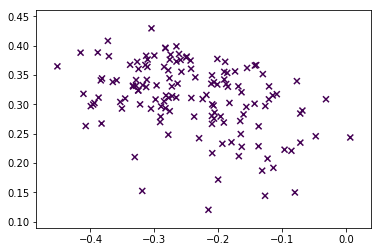

In [471]:
# plt.scatter(pred[:n, 1], pred[:n, 2], c=(true[:n] + 1) % 2, marker='o')
plt.hold(True)
plt.scatter(pred[:n, 1], pred[:n, 2], marker='x', c=hdb_pred)
plt.hold(False)

In [439]:
plt.scatter?

In [413]:
pred.shape

(138, 3, 1)

In [382]:
p, n = next(batch_gen)

/home/fogside/virtens/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead


In [275]:
p = np.sum(p, axis=0)
n = np.sum(n, axis=0)

In [276]:
wv.similar_by_vector(p)

[('а', 0.8541556596755981),
 ('г', 0.8488138914108276),
 ('н', 0.8453353643417358),
 ('же', 0.8379328846931458),
 ('о', 0.8367843627929688),
 ('константинова', 0.8338011503219604),
 ('покойный', 0.8336784839630127),
 ('сам', 0.8316569924354553),
 ('тот', 0.8305151462554932),
 ('тогда', 0.8270591497421265)]

In [200]:
wv.similar_by_vector(s)

[('предмет', 0.8658064603805542),
 ('изделие', 0.8496578335762024),
 ('изготовляться', 0.8273499608039856),
 ('неполированный', 0.8218017220497131),
 ('изготовление', 0.8217644095420837),
 ('ткань', 0.8210477828979492),
 ('остальное', 0.8169079422950745),
 ('вещь', 0.8153163194656372),
 ('керамика', 0.8123542070388794),
 ('пластика', 0.8065093755722046)]

In [540]:
def train_model(f, word, cmp=3):

    tf.reset_default_graph()
    lr = 1e-2
    n_comps = cmp
    net = MultiComp(100, n_comps, 0.1)


    n_samples = len(f)
    n_context = 10 # number of words in the context
    emb_dim = 100
    atts = list()
    epoch_num = 5
    losses = []
    for epoch in range(epoch_num):
    #     batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
        batch_gen = generate_triplet_batch(f, context_max_len=10, word=word, lemmatize=True)
        pbar = tqdm_notebook(batch_gen, total = n_samples)
        print("epoch_num: ", epoch)
        for n, (sample_p, sample_n) in enumerate(pbar):
            if len(sample_p)==0:
                continue

            loss, att = net.train_on_sample(sample_p, sample_n, lr)
            atts.append(att)
            losses.append(loss)

            if n % 100 == 99:
                pbar.set_description("loss {:.3f}".format(float(np.mean(losses[-300:]))))
    return net

In [353]:
a.shape

(1380, 10)

/home/fogside/virtens/py3/lib/python3.6/site-packages/seaborn/distributions.py:645: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)


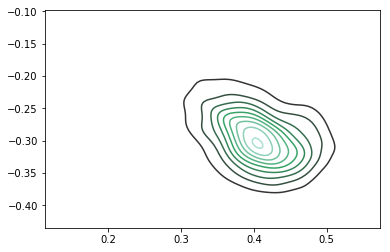

In [355]:
sns.kdeplot(a[:,2:4])

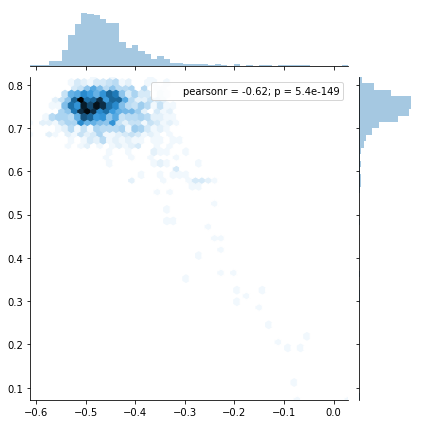

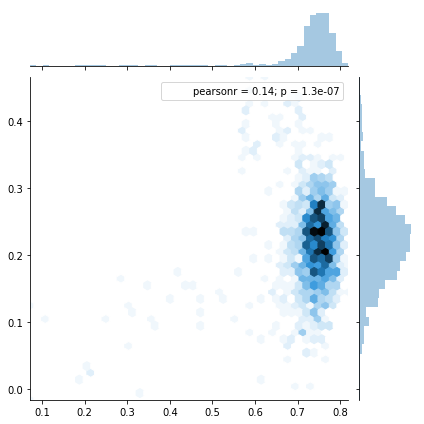

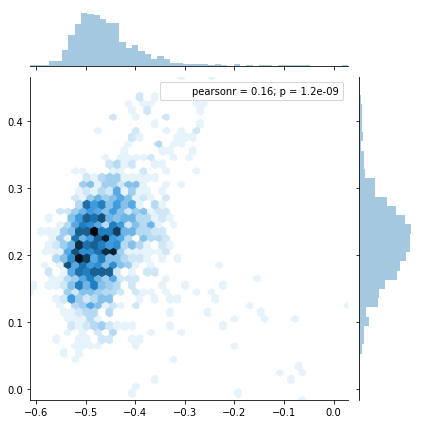

In [384]:
import seaborn as sns

a = np.array(atts).squeeze()
a.shape
sns.jointplot(a[:, 0], a[:, 1], kind="hex")
sns.jointplot(a[:, 1], a[:, 2], kind="hex")
sns.jointplot(a[:, 0], a[:, 2], kind="hex")

# CENTROIDS

In [377]:
class MultiCompCentroids:
    def __init__(self, emb_size, n_comp, margin):
        self.pos = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='pos_ph')
        self.neg = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='neg_ph')
        self.lr = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')

        comp_init = np.random.randn(n_comp, emb_size) / np.sqrt(emb_size * n_comp)
        self.sense_comps = tf.Variable(comp_init, dtype=tf.float32, name='senses')
        self.centroids = tf.Variable(comp_init, dtype=tf.float32, name='centroids')
        
        # Attention
        mean_cont = tf.reduce_mean(self.pos, axis=0, keep_dims=True)
        mean_cont = tf.nn.l2_normalize(mean_cont, 1)  # 1 x 100
        
        norm_centroids = tf.nn.l2_normalize(self.centroids, 1) # n_comp x 100
        
        att = tf.reduce_sum(mean_cont * norm_centroids, axis=1, keep_dims=True)
        self.att = tf.nn.softmax(att, dim=0)
        
        max_index = tf.cast(tf.argmax(self.att)[0], tf.int32)
        print(max_index)
#         print(mean_cont)
#         print(self.centroids[max_index[0]])
        # Update centroids
        self.centroids[max_index].assign(mean_cont + self.centroids[max_index])
#         self.centroids[max_index[0]]+= mean_cont
        
        
#         word_emb = self.sense_comps * self.att, axis=0, keep_dims=True)
#         word_emb = tf.reduce_sum(self.sense_comps * self.att, axis=0, keep_dims=True)
        
        
        # Cosine loss
        norm_pos = tf.nn.l2_normalize(self.pos, 1)
        norm_neg = tf.nn.l2_normalize(self.neg, 1)
        norm_word_emb = tf.nn.l2_normalize(self.sense_comps[max_index], dim=0)
        
        pos_loss = tf.reduce_mean(tf.reduce_sum(norm_pos * norm_word_emb, axis=1))
        neg_loss = tf.reduce_mean(tf.reduce_sum(norm_neg * norm_word_emb, axis=1))
        
        self.loss = -pos_loss # + neg_loss + 1e-3*tf.nn.l2_loss(self.sense_comps)
        opt = tf.train.AdamOptimizer(self.lr)
        self.train_op = opt.minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train_on_sample(self, pos_samp, neg_samp, learning_rate):
        feed_dict = {self.pos: pos_samp, self.neg: neg_samp, self.lr: learning_rate}
        loss, att, _ = self.sess.run([self.loss, self.att, self.train_op], feed_dict)
        return loss, att

# Train

In [17]:
w_emb = wv['замок'].reshape((1,100))
lr = 1e-2
n_comps = 2
net = MultiCompCentroids(100, n_comps, 0.1)


n_samples = len(lines)
n_context = 10 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 1
losses = []
for epoch in range(epoch_num):
    batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, (sample_p, sample_n) in enumerate(pbar):
        if len(sample_p)==0:
            continue
        
        loss, att = net.train_on_sample(sample_p, sample_n, lr)
        atts.append(att)
        losses.append(loss)
        
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(np.mean(losses[-300:]))))

Tensor("Cast:0", shape=(), dtype=int32)


HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0


/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead
  del sys.path[0]


In [9]:
tf.__version__

'1.5.0'

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
tfidf = TfidfVectorizer()
vals = tfidf.fit_transform(lines)
num = tfidf.vocabulary_['замок']
vals[1, num]

In [139]:
!head -n 20 ../data/my_data/замок_out.txt

лен и льняной ткань серебряный вещь пряслица из розовый шифер замок резной кость и пр а предмет ввоз быть предмет
к юг от кисловодск в number number км высоко от замок один из местный достопримечательность здесь выходить на поверхность розовый
город становиться классицизм основной архитектор этот стиль в и баженов замок ж б валлен деламот здание академия художество большой гостиный
правление франциск i во французский архитектура наступать эпоха возрождение хорошо замок в долина луара шамбор шенонсо шевертывать блуа азэ ле
становиться фактический столица в number год когда после пожар в замок в краков король сигизмунд iii перенести свой резиденция сюда
город быть уничтожать в частность исторический место стар мястый и замок
граница с калининградский область россия основывать в number год как замок мариенбург население number житель number
замок мариенбург самый большой в мир кирпичный замок служить резиденция магистр тевтонский орден занимать площадь свыше number гектар в number замок б

# Visualize

### Sense vectors:

In [385]:
vecs = net.sess.run(net.sense_comps)
vecs.shape

(3, 100)

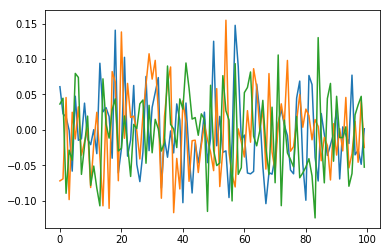

In [387]:
plt.plot(vecs[0])
plt.plot(vecs[1])
plt.plot(vecs[2])

# plt.plot(wv['замок']/wv['замок'].std(), label='замок')
# plt.legend()
plt.show()

### Attention:

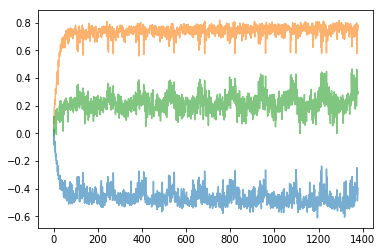

In [388]:
plt.plot(np.array(atts).squeeze(), alpha=0.6)
plt.show()

In [389]:
np.array(atts).squeeze().shape

(1380, 3)

### Losses:

In [82]:
def window_average(arr, w_len=10):
    return [np.mean(i) for i in np.split(arr, w_len,)]

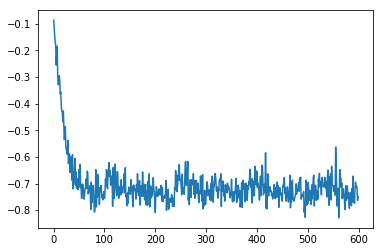

In [390]:
plt.plot(np.array(losses[:600]).squeeze())
plt.show()

In [288]:
kek = np.array(losses).squeeze()
lol = window_average(kek, 26)
plt.plot(lol)
plt.show()

ValueError: array split does not result in an equal division

### Word similarity

In [393]:
vecs = net.sess.run(net.sense_comps)

In [392]:
v = np.sum(vecs * atts[-1], 0)
# v = vecs[2]
z = wv['замок']

print(np.dot(v, z) / np.linalg.norm(v, 2) / np.linalg.norm(z, 2) )

0.73077786


In [376]:
wv.similar_by_vector(-vecs[2])

[('изумлять', 0.7135107517242432),
 ('и', 0.7124948501586914),
 ('его', 0.7119195461273193),
 ('некогда', 0.7115745544433594),
 ('весь', 0.7066596150398254),
 ('наконец', 0.7033094167709351),
 ('потрясать', 0.7004733681678772),
 ('себя', 0.6993831396102905),
 ('судя', 0.6978541612625122),
 ('остия', 0.6968574523925781)]

In [361]:
v = np.sum(vecs * atts[-1], 0)
wv.similar_by_vector(v, 30)

[('и', 0.9365314245223999),
 ('этот', 0.933408260345459),
 ('в', 0.9333837628364563),
 ('который', 0.9295867085456848),
 ('другой', 0.9287702441215515),
 ('тот', 0.9251302480697632),
 ('только', 0.9192702770233154),
 ('весь', 0.9190534353256226),
 ('время', 0.9141498804092407),
 ('один', 0.9134024381637573),
 ('однако', 0.9095531702041626),
 ('как', 0.9085384607315063),
 ('с', 0.9081577658653259),
 ('причем', 0.9075477719306946),
 ('же', 0.9050619602203369),
 ('из', 0.9038644433021545),
 ('самый', 0.902309775352478),
 ('уже', 0.9016097784042358),
 ('некоторый', 0.9008409976959229),
 ('они', 0.900243878364563),
 ('естественно', 0.9001370072364807),
 ('можно', 0.8993648886680603),
 ('а', 0.8974071741104126),
 ('наш', 0.8947985172271729),
 ('поскольку', 0.8947714567184448),
 ('даже', 0.8946974277496338),
 ('последний', 0.8945205211639404),
 ('еще', 0.8941351175308228),
 ('первый', 0.8937762975692749),
 ('или', 0.893467903137207)]

In [394]:
wv.similar_by_vector(vecs[0], 40)

[('хліб', 0.2327604442834854),
 ('луюч', 0.23223304748535156),
 ('зюм', 0.22837138175964355),
 ('єжи', 0.22697466611862183),
 ('схлип', 0.2235499620437622),
 ('схлипуючи', 0.22137796878814697),
 ('схлипує', 0.21323958039283752),
 ('яжу', 0.2125093638896942),
 ('задерша', 0.19938603043556213),
 ('хустц', 0.19758345186710358),
 ('їжею', 0.19585084915161133),
 ('вйо', 0.19494178891181946),
 ('шлюб', 0.18953284621238708),
 ('жг', 0.18880531191825867),
 ('пташок', 0.1883796751499176),
 ('їжте', 0.1879940629005432),
 ('яєчню', 0.1839980185031891),
 ('жужмом', 0.18363776803016663),
 ('уляся', 0.18211892247200012),
 ('мюжгян', 0.18140047788619995),
 ('кашляє', 0.18119022250175476),
 ('гшись', 0.18008701503276825),
 ('ланцюжок', 0.17687630653381348),
 ('схлипывать', 0.1733936369419098),
 ('цц', 0.17258334159851074),
 ('хлип', 0.1711139976978302),
 ('чарц', 0.1708437204360962),
 ('шп', 0.16895166039466858),
 ('юзек', 0.1687793731689453),
 ('укл', 0.16851361095905304),
 ('хапаючи', 0.167948350310

In [395]:
wv.similar_by_vector(vecs[1], 20)

[('в', 0.800079345703125),
 ('второй', 0.7862643599510193),
 ('и', 0.7846736311912537),
 ('с', 0.7775000333786011),
 ('тот', 0.7770915031433105),
 ('третий', 0.7769326567649841),
 ('один', 0.7763150930404663),
 ('через', 0.7711653113365173),
 ('когда', 0.769650399684906),
 ('два', 0.768782377243042),
 ('равинять', 0.7677798271179199),
 ('преспокойный', 0.7670109868049622),
 ('последний', 0.7652555108070374),
 ('другой', 0.763597309589386),
 ('приставляться', 0.7628967761993408),
 ('а', 0.7623950242996216),
 ('из', 0.7597670555114746),
 ('со', 0.7590359449386597),
 ('уже', 0.758962869644165),
 ('тогда', 0.7569724321365356)]

In [396]:
wv.similar_by_vector(vecs[2], 20)

[('кодированный', 0.5629267692565918),
 ('передаваемый', 0.5241020917892456),
 ('биометрический', 0.5236515402793884),
 ('радиочастота', 0.5182679891586304),
 ('радиосистема', 0.515855073928833),
 ('коротковолновый', 0.5158207416534424),
 ('фоновый', 0.5154492855072021),
 ('мониторный', 0.5092576742172241),
 ('широкополосный', 0.5061536431312561),
 ('радиочастотный', 0.5050608515739441),
 ('передача', 0.5047511458396912),
 ('частота', 0.5045921802520752),
 ('диапазон', 0.5029609203338623),
 ('факсовый', 0.5029041767120361),
 ('скремблер', 0.5025793313980103),
 ('кодирование', 0.5024082660675049),
 ('радиообмен', 0.4997626543045044),
 ('спутниковый', 0.49775099754333496),
 ('распечатка', 0.49635058641433716),
 ('лингафонный', 0.49525463581085205)]

# Weighted similarities

In [151]:
p = atts[-5:]
p

[array([[0.59179115],
        [0.40820885]], dtype=float32), array([[0.5793171 ],
        [0.42068288]], dtype=float32), array([[0.5958263],
        [0.4041736]], dtype=float32), array([[0.5720039 ],
        [0.42799604]], dtype=float32), array([[0.6178629 ],
        [0.38213718]], dtype=float32)]

In [152]:
for p in atts[-5:]:
    print(p)
    print("---")

[[0.59179115]
 [0.40820885]]
---
[[0.5793171 ]
 [0.42068288]]
---
[[0.5958263]
 [0.4041736]]
---
[[0.5720039 ]
 [0.42799604]]
---
[[0.6178629 ]
 [0.38213718]]
---


In [118]:
vecs.shape

(3, 100)

In [119]:
lol = np.sum(p*vecs, axis=0)
lol.shape

(100,)

In [116]:
wv.similar_by_vector(lol, 200)

[('от', 0.7358344197273254),
 ('который', 0.7354562282562256),
 ('из', 0.7353567481040955),
 ('как', 0.7331260442733765),
 ('один', 0.7306678891181946),
 ('во', 0.7306039333343506),
 ('со', 0.7302639484405518),
 ('самый', 0.7287554740905762),
 ('и', 0.7273545265197754),
 ('весь', 0.7255203723907471),
 ('когда', 0.7240930795669556),
 ('оно', 0.7240872383117676),
 ('в', 0.7235139012336731),
 ('тот', 0.7219510674476624),
 ('только', 0.7215321063995361),
 ('другой', 0.7211594581604004),
 ('оба', 0.7186580300331116),
 ('за', 0.7165206074714661),
 ('ни', 0.7142389416694641),
 ('перед', 0.7136077284812927),
 ('же', 0.7124976515769958),
 ('можно', 0.7106633186340332),
 ('место', 0.7095289826393127),
 ('так', 0.7073025703430176),
 ('треть', 0.7062292098999023),
 ('чем', 0.7061398029327393),
 ('мочь', 0.7058018445968628),
 ('большой', 0.705718457698822),
 ('то', 0.7053390145301819),
 ('нет', 0.7048940658569336),
 ('конец', 0.7036462426185608),
 ('раз', 0.7035396099090576),
 ('рано', 0.7030260562

# Overfit

In [105]:
class MultiCompOvertrain:
    def __init__(self, emb_size, n_comp, margin):
        self.pos = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='pos_ph')
#         self.neg = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='neg_ph')
        self.lr = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')

        comp_init = np.random.randn(n_comp, emb_size) / np.sqrt(emb_size * n_comp)
        self.sense_comps = tf.Variable(comp_init, dtype=tf.float32, name='senses')
        
        # Attention
        mean_cont = tf.reduce_mean(self.pos, axis=0, keep_dims=True)
        mean_cont = tf.nn.l2_normalize(mean_cont, 1)  # 1 x 100
        
        norm_sens = tf.nn.l2_normalize(self.sense_comps, 1) # n_comp x 100
        
        att = tf.reduce_sum(mean_cont * norm_sens, axis=1, keep_dims=True)
        self.att = tf.nn.softmax(att, dim=0)
        word_emb = tf.reduce_sum(self.sense_comps * self.att, axis=0, keep_dims=True)
        
        
        # Cosine loss
        norm_pos = tf.nn.l2_normalize(self.pos, 1)
#         norm_neg = tf.nn.l2_normalize(self.neg, 1)
        norm_word_emb = tf.nn.l2_normalize(word_emb, 1)
        
        pos_loss = tf.reduce_mean(tf.reduce_sum(norm_pos * norm_word_emb, axis=1))
#         neg_loss = tf.reduce_mean(tf.reduce_sum(norm_neg * norm_word_emb, axis=1))
        
        self.loss = -pos_loss #+ 1e-3*tf.nn.l2_loss(self.sense_comps)
#         opt = tf.train.AdamOptimizer(self.lr)
        opt = tf.train.GradientDescentOptimizer(learning_rate=self.lr)
        self.grads_and_vars = opt.compute_gradients(self.loss)
        self.train_op = opt.apply_gradients(self.grads_and_vars)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train_on_sample(self, pos_samp, learning_rate):
        feed_dict = {self.pos: pos_samp, self.lr: learning_rate}
        loss, att, _ = self.sess.run([self.loss, self.att, self.train_op], feed_dict)
        gradvar = self.sess.run(self.grads_and_vars, feed_dict)
        return loss, att, gradvar

In [106]:
tf.reset_default_graph()
net = MultiCompOvertrain(100, n_comps, 0.1)

print(tf.trainable_variables())
l,_, gv = net.train_on_sample(sample_p, 1)
print(l)

[<tf.Variable 'senses:0' shape=(2, 100) dtype=float32_ref>]
-0.023266569


In [107]:
l,_, gv = net.train_on_sample(sample_p, 1)
print(l)

-0.7820913


In [108]:
print(gv[0][1] - var1)

[[-0.18851432  0.21875733 -0.06706028 -0.13663545 -0.12154876 -0.04777572
   0.06399444  0.06880708 -0.10984476 -0.05064923  0.00717373 -0.11175838
  -0.01792912  0.03080618 -0.03327873 -0.12629704 -0.13660094 -0.05163753
   0.0446002   0.08272374  0.07438624  0.18066257 -0.06388314 -0.00513199
  -0.01538289 -0.1217225   0.12070465  0.14994213  0.09723291  0.04533161
   0.13186687  0.0892374   0.01157376 -0.25128204 -0.03162968  0.01206909
  -0.09524553 -0.02607945  0.15684846 -0.05309853 -0.09015401  0.11796028
   0.00362326 -0.02660781 -0.1504022   0.05854211  0.22595127 -0.02572927
  -0.10819298 -0.03715308 -0.15439323 -0.03692684  0.0200675   0.19425777
  -0.00510252  0.04842892 -0.2884487  -0.02709235 -0.06462163  0.05031693
   0.01522227  0.00533152 -0.1467613  -0.09653531 -0.07696746  0.00713161
  -0.0205721  -0.03807064  0.08686125  0.23606153 -0.08108035 -0.13647327
  -0.13768734 -0.12157448 -0.00035132 -0.08121265  0.03659559  0.08409844
  -0.15819387  0.07890879 -0.03334813 

In [51]:
net.grads_and_vars

[(<tf.Tensor 'gradients/AddN_1:0' shape=(2, 100) dtype=float32>,
  <tf.Variable 'senses:0' shape=(2, 100) dtype=float32_ref>)]

In [149]:
tf.reset_default_graph()

lr = 1e-2
n_comps = 1
net = MultiCompOvertrain(100, n_comps, 0.1)


n_samples = len(lines)
n_context = 10 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 1
losses = []
batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
# pbar = tqdm_notebook(batch_gen, total = n_samples)
pbar = tqdm_notebook(range(n_samples))

for epoch in range(epoch_num):
    print("epoch_num: ", epoch)
    for n in pbar:
        
        loss, att, _ = net.train_on_sample([wv['замок']], lr)
        atts.append(att)
        losses.append(loss)
        
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(loss)))

HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0


KeyboardInterrupt: 

In [36]:
batch_gen = generate_triplet_batch(lines, context_max_len=n_context)

In [38]:
sample_p, sample_n = next(batch_gen)

/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead
  del sys.path[0]


In [39]:
sample_p

array([[-5.6586e-02, -4.3405e-01,  5.7687e-02,  9.4219e-02,  1.8545e-01,
         2.1660e-02,  2.0502e-01, -1.2822e-01, -1.0966e-01,  8.4513e-02,
        -5.0039e-01, -1.7734e-02,  1.4663e-01, -4.9800e-01, -3.5856e-01,
         1.5300e-01, -5.0116e-01,  2.5637e-01, -7.3133e-02, -1.5731e-01,
         5.2461e-01, -6.6332e-02,  3.8662e-01,  2.0060e-02, -1.4579e-01,
        -4.6512e-02,  2.7343e-02, -1.2710e-01, -7.1486e-02,  6.4479e-01,
         2.2555e-01,  2.0896e-01,  1.1489e-01, -2.1602e-01,  1.4261e-01,
         2.4632e-01,  2.7624e-01, -1.3323e-01, -1.5254e-01, -2.3404e-01,
        -1.0259e-01, -1.6554e-02, -7.9704e-02, -1.5958e-02,  2.9684e-01,
        -1.5963e-01, -7.1483e-02,  3.1222e-02, -1.4836e-01,  2.5009e-01,
        -6.3984e-01,  2.2365e-01, -3.6046e-01,  9.4387e-02,  6.8341e-01,
         2.4043e-01, -7.7723e-02, -2.3697e-01, -1.3673e-01, -4.2327e-02,
        -2.4044e-01,  2.5731e-01,  1.0817e-01,  7.0586e-03,  2.0710e-01,
        -3.6737e-02,  2.1166e-01, -1.1527e-01,  2.4